In [44]:
# !pip install seaborn
import wandb
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
sns.set_theme(style="white", palette='colorblind')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [24]:
def vmap_smooth(scalars: np.array, weight: float):  # Weight between 0 and 1
    last = scalars[..., 0]  # First value in the plot (first timestep)
    smoothed = list()
    for i in range(scalars.shape[-1]):
        smoothed_val = last * weight + (1 - weight) * scalars[..., i]  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return np.stack(smoothed, axis=-1)

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

# N-Player Shaping

In [42]:


api = wandb.Api()

In [57]:
# globals: path, ylims, game_name
path = '/Users/timonwilli/Documents/nshaper_figs/'
ylims = {'sd_3':(0,3), 'sd_4':(0,4), 'sd_5':(0,5), 'sh_3':(-3,4), 'sh_4':(-3,4.5), 'sh_5':(-3,4.8), 'tc_3':(-3,5), 'tc_4':(-3,5), 'tc_5':(-3,5), 'ipd_3':(0,5), 'ipd_4':(0,7), 'ipd_5':(0,9)}
game_name = {'sd': 'Snowdrift', 'ipd': 'Prisoner\'s Dilemma', 'sh': 'Stag Hunt', 'tc': 'Tragedy of the Commons'}


def plot_naive_rewards(game,num_pl,smooth_factor=0.99):
    runs = api.runs(path="ucl-dark/tensor",
     filters={"config.wandb.group": f"naive_{num_pl}pl_{game}"})
    plt.figure()
    rewards_dict = {pl_idx: [] for pl_idx in range(num_pl)}
    xs = []

    for run in runs:
        rew_keys = [f'train/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_pl)]
        df = run.scan_history(keys=rew_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        for pl_idx in range(num_pl):
            rewards_dict[pl_idx].append([row[f'train/reward_per_timestep/player_{pl_idx+1}'] for row in df])
    _xs = np.array(xs)
    smooth_rewards_dict = {pl_idx: vmap_smooth(np.array(rewards_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl)}


    x = _xs[0, :]
    medians = {pl_idx: np.median(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}
    stds = {pl_idx: np.std(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}

    for pl_idx in range(num_pl):
        plt.plot(x, medians[pl_idx], label=f"NL {pl_idx+1}")
        plt.fill_between(x, medians[pl_idx]-stds[pl_idx], medians[pl_idx]+stds[pl_idx], alpha=0.2)

    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(ylims[f'{game}_{num_pl}'][0], ylims[f'{game}_{num_pl}'][1])

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("Reward Per Timestep", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_pl} Naive PPO Memory agents", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/training/", exist_ok=True)
    plt.savefig(path+f"{game}/{num_pl}_pl/training/rewards.png", bbox_inches='tight')
    return plt

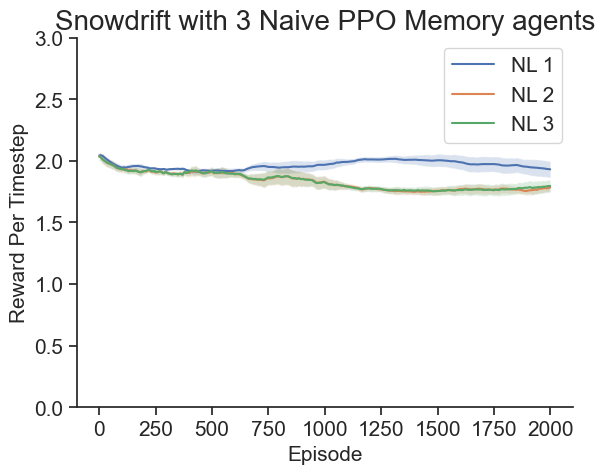

In [53]:
# /Users/timonwilli/Documents/nshaper_figs/sd/3pl/eval/name.png
plot_naive_rewards("sd",3).show()

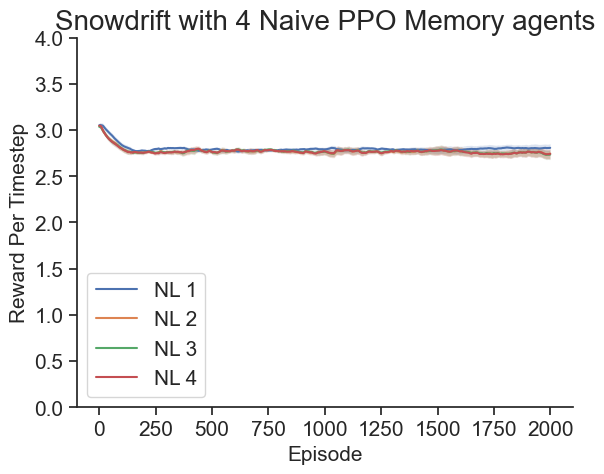

In [54]:
plot_naive_rewards("sd",4).show()

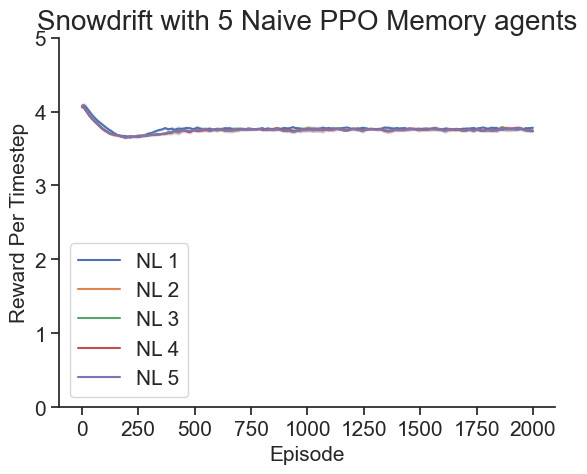

In [55]:
plot_naive_rewards("sd",5).show()

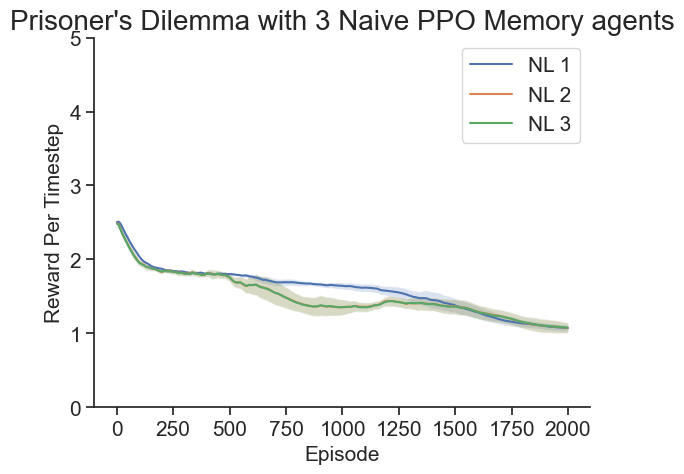

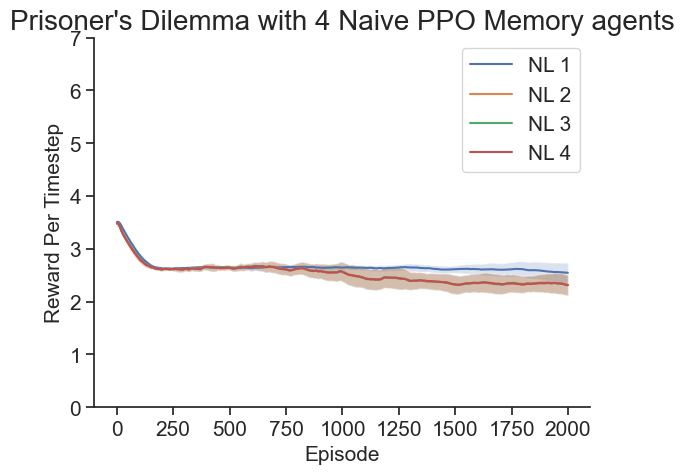

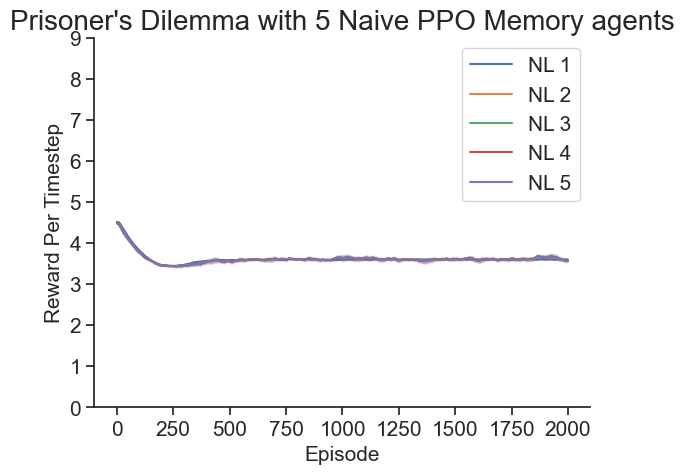

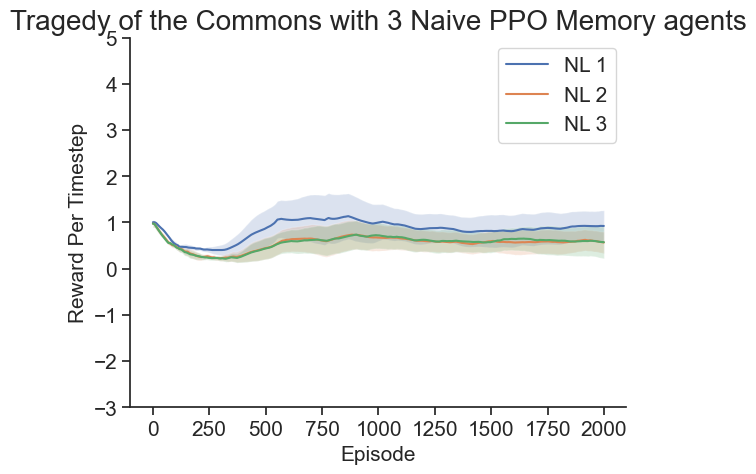

In [58]:
plot_naive_rewards("ipd",3).show()
plot_naive_rewards("ipd",4).show()
plot_naive_rewards("ipd",5).show()

plot_naive_rewards("tc",3).show()
plot_naive_rewards("tc",4).show()
plot_naive_rewards("tc",5).show()

plot_naive_rewards("sh",3).show()
plot_naive_rewards("sh",4).show()
plot_naive_rewards("sh",5).show()

# Training Runs

In [5]:
import wandb
api = wandb.Api()
run = api.run("/ucl-dark/ipditm/1vpl5161")


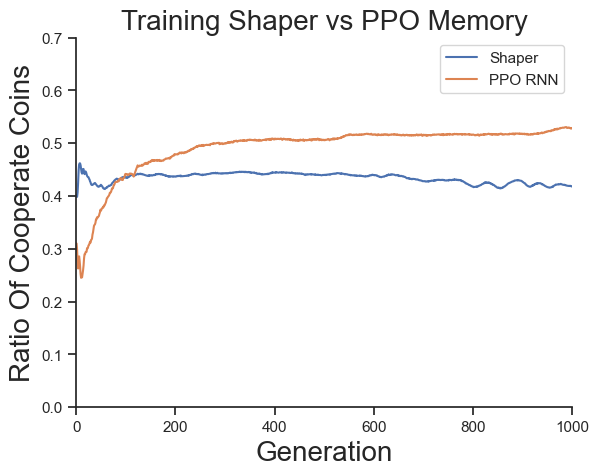

In [6]:
figure_name = "ipditm/train/shaper_ratio"
df = run.scan_history(keys=['train_iteration', 'ratio/1', 'ratio/2'])
train_iteration = [row['train_iteration'] for row in df]
ratio_1 = [row['ratio/1'] for row in df]
ratio_2 = [row['ratio/2'] for row in df]

plt.plot(train_iteration, ratio_1, label='Shaper')
plt.plot(train_iteration, ratio_2, label='PPO RNN')

plt.xlabel("Generation", fontsize=20)
plt.ylabel("Ratio Of Cooperate Coins", fontsize=20)
plt.title("Training Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.xlim(0, 1000)
plt.ylim(0, 0.7)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

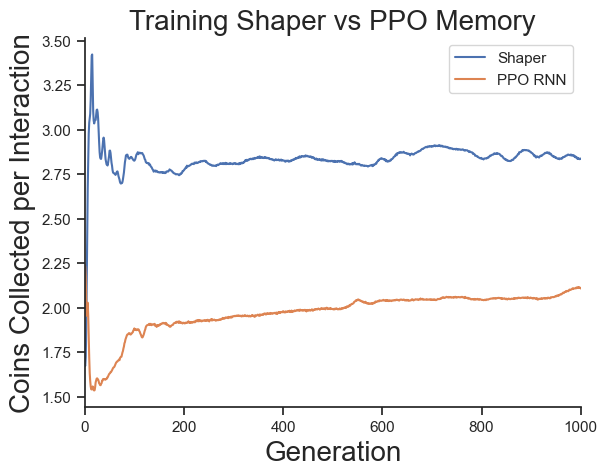

In [37]:
figure_name = "ipditm/train/shaper_coins"
df = run.scan_history(keys=['train_iteration', 'total_coin/1', 'total_coin/2'])
train_iteration = [row['train_iteration'] for row in df]
y1 = [row['total_coin/1'] for row in df]
y2 = [row['total_coin/2'] for row in df]

plt.plot(train_iteration, y1, label='Shaper')
plt.plot(train_iteration, y2, label='PPO RNN')

plt.xlabel("Generation", fontsize=20)
plt.ylabel("Coins Collected per Interaction", fontsize=20)
plt.title("Training Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.xlim(0, 1000)
# plt.ylim(0, 0.7)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

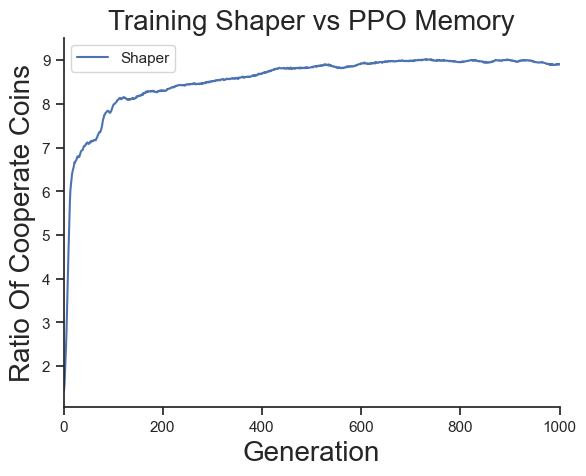

In [38]:
figure_name = "ipditm/train/shaper_resets"
df = run.scan_history(keys=['train_iteration', 'num_soft_resets'])
train_iteration = [row['train_iteration'] for row in df]
y1 = [row['num_soft_resets'] / 500 for row in df]

plt.plot(train_iteration, y1, label='Shaper')
# plt.plot(train_iteration, y2, label='PPO RNN')

plt.xlabel("Generation", fontsize=20)
plt.ylabel("Ratio Of Cooperate Coins", fontsize=20)
plt.title("Training Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.xlim(0, 1000)
# plt.ylim(0, 0.7)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

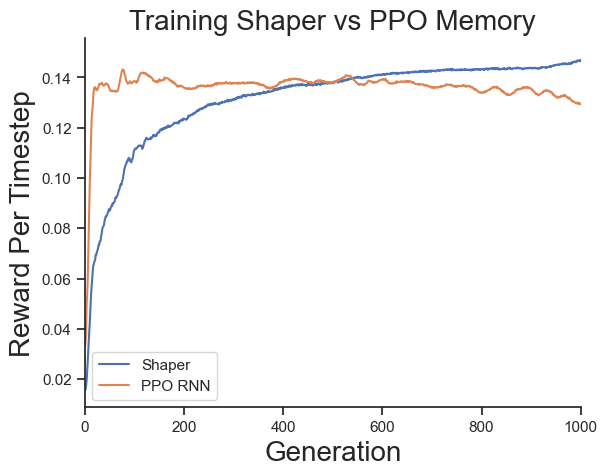

In [39]:
figure_name = "ipditm/train/shaper_reward"
df = run.scan_history(keys=['train_iteration', 'train/reward_per_timestep/player_1', 'train/reward_per_timestep/player_2'])
train_iteration = [row['train_iteration'] for row in df]
y1 = [row['train/reward_per_timestep/player_1']  for row in df]
y2 = [row['train/reward_per_timestep/player_2']  for row in df]

plt.plot(train_iteration, y1, label='Shaper')
plt.plot(train_iteration, y2, label='PPO RNN')

plt.xlabel("Generation", fontsize=20)
plt.ylabel("Reward Per Timestep", fontsize=20)
plt.title("Training Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.xlim(0, 1000)
# plt.ylim(0, 0.7)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

# Evaluation Runs Shaper

In [40]:
import wandb
api = wandb.Api()
runs = api.runs(path="ucl-dark/ipditm",
 filters={"config.wandb.group": "shaper-eval-PPO_memory-vs-PPO_memory", "tags": {"$in": ["icml-final"]}})


baseline_runs = api.runs(path="ucl-dark/ipditm",
 filters={"config.wandb.group": "sanity-PPO_memory-vs-PPO_memory", "tags": {"$in": ["icml-final"]}})

## Ratio

In [41]:
xs, ys, zs = [], [], []

for run in runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'ratio/1', 'ratio/2'])
    xs.append([row['train_iteration'] for row in df])
    ys.append([row['ratio/1'] for row in df])
    zs.append([row['ratio/2'] for row in df])

bxs, bys = [], []
for run in baseline_runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'ratio/1'])
    bxs.append([row['train_iteration'] for row in df])
    bys.append([row['ratio/1'] for row in df])

run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0
run-seed-7| fixed-coin=False
run-seed-5| fixed-coin=False
run-seed-3| fixed-coin=False
run-seed-1| fixed-coin=False
run-seed-0 | fixed-coin=False


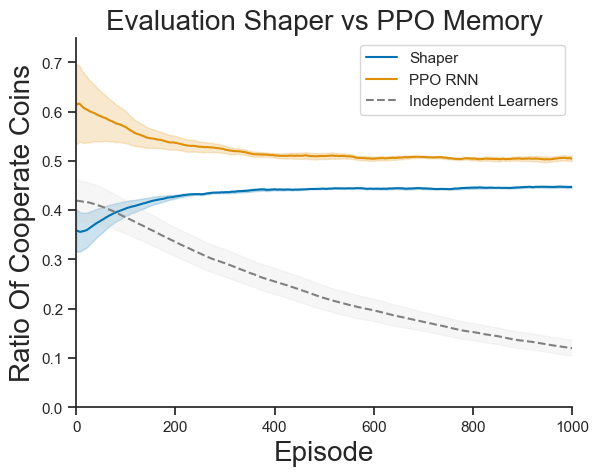

In [42]:
figure_name = "ipditm/eval/shaper_ratio"
smooth_factor = 0.99

_xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Shaper", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Ratio Of Cooperate Coins", fontsize=20)
plt.title("Evaluation Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")


#Baseline
_bxs = np.array(bxs)
_bys = vmap_smooth(np.array(bys), smooth_factor)
bx = _bxs[0, :]
by = np.median(_bys, axis=0)
by_std = np.std(_bys, axis=0)

plt.plot(bx, by, label="Independent Learners", color='Gray', linestyle='--')
plt.fill_between(bx, by - by_std, by + by_std, color='lightgrey', alpha=0.2)

plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.ylim(0, 0.75)

plt.savefig(f"{figure_name}.png", bbox_inches='tight')

## Number of Coins

In [43]:
xs, ys, zs = [], [], []

for run in runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'total_coin/1', 'total_coin/2'])
    xs.append([row['train_iteration'] for row in df])
    ys.append([row['total_coin/1'] for row in df])
    zs.append([row['total_coin/2'] for row in df])

bxs, bys = [], []
for run in baseline_runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'total_coin/1'])
    bxs.append([row['train_iteration'] for row in df])
    bys.append([row['total_coin/1'] for row in df])


run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0
run-seed-7| fixed-coin=False
run-seed-5| fixed-coin=False
run-seed-3| fixed-coin=False
run-seed-1| fixed-coin=False
run-seed-0 | fixed-coin=False


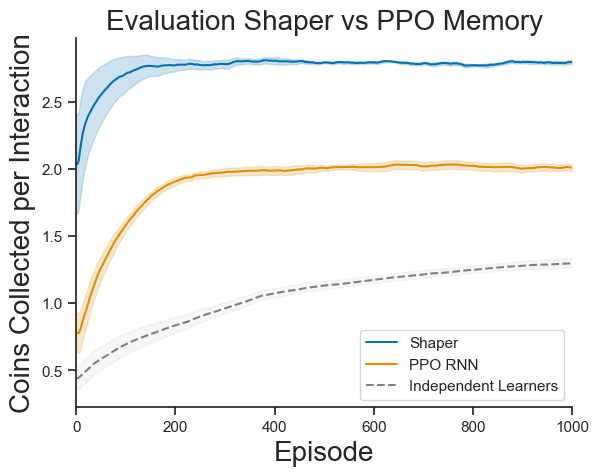

In [44]:
figure_name = "ipditm/eval/shaper_total_coins"
smooth_factor = 0.99

_xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Shaper", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)

# plt.legend(loc="lower right")
_bxs = np.array(bxs)
_bys = vmap_smooth(np.array(bys), smooth_factor)
bx = _bxs[0, :]
by = np.median(_bys, axis=0)
by_std = np.std(_bys, axis=0)


plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Coins Collected per Interaction", fontsize=20)
plt.title("Evaluation Shaper vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")

# baseline
plt.plot(bx, by, label="Independent Learners", color='Gray', linestyle='--')
plt.fill_between(bx, by - by_std, by + by_std, color='lightgrey', alpha=0.2)

plt.legend()
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

## Reward

In [45]:
## Reward Per Episode
xs, ys, zs = [], [], []

keys = ['train_iteration', 'train/total_reward/player_1', 'train/total_reward/player_2']
for run in runs:
    print(run.name)
    df = run.scan_history(keys=keys)
    xs.append([row[keys[0]] for row in df])
    ys.append([row[keys[1]] for row in df])
    zs.append([row[keys[2]] for row in df])

bxs, bys = [], []
for run in baseline_runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'train/total_reward/player_1'])
    bxs.append([row['train_iteration'] for row in df])
    bys.append([row['train/total_reward/player_1'] for row in df])

run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0
run-seed-7| fixed-coin=False
run-seed-5| fixed-coin=False
run-seed-3| fixed-coin=False
run-seed-1| fixed-coin=False
run-seed-0 | fixed-coin=False


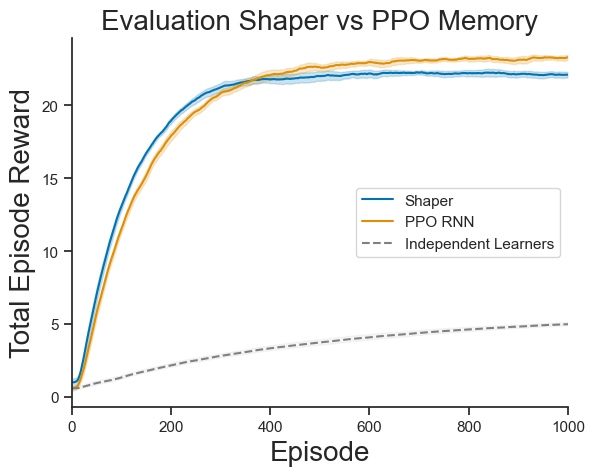

In [46]:
figure_name = "ipditm/eval/shaper_episode_reward"
smooth_factor = 0.99

xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Shaper", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)

# baseline
_bxs = np.array(bxs)
_bys = vmap_smooth(np.array(bys), smooth_factor)
bx = _bxs[0, :]
by = np.median(_bys, axis=0)
by_std = np.std(_bys, axis=0)

plt.plot(bx, by, label="Independent Learners", color='Gray', linestyle='--')
plt.fill_between(bx, by - by_std, by + by_std, color='lightgrey', alpha=0.2)
# plt.legend(loc="lower right")

plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Total Episode Reward", fontsize=20)
plt.title("Evaluation Shaper vs PPO Memory",fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

# Evaluation Runs Pre-trained Independent

In [47]:
import wandb
api = wandb.Api()
runs = api.runs(path="ucl-dark/ipditm",
 filters={
    "config.wandb.group": "shaper-eval-independent-vs-PPO_memory", "tags": {"$in": ["icml-final"]}})

## Ratio

In [48]:
xs, ys, zs = [], [], []

for run in runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'ratio/1', 'ratio/2'])
    xs.append([row['train_iteration'] for row in df])
    ys.append([row['ratio/1'] for row in df])
    zs.append([row['ratio/2'] for row in df])

run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0


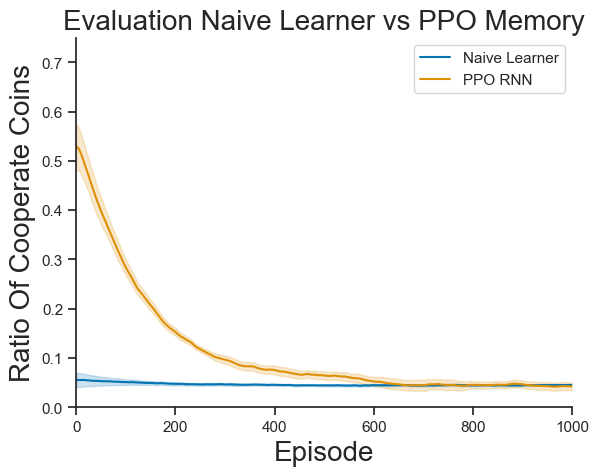

In [49]:
figure_name = "ipditm/eval/independent_ratio"
smooth_factor = 0.99

_xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Naive Learner", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Ratio Of Cooperate Coins", fontsize=20)
plt.title("Evaluation Naive Learner vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")


plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.ylim(0, 0.75)

plt.savefig(f"{figure_name}.png", bbox_inches='tight')

## Total Coins

In [50]:
xs, ys, zs = [], [], []

for run in runs:
    print(run.name)
    df = run.scan_history(keys=['train_iteration', 'total_coin/1', 'total_coin/2'])
    xs.append([row['train_iteration'] for row in df])
    ys.append([row['total_coin/1'] for row in df])
    zs.append([row['total_coin/2'] for row in df])



run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0


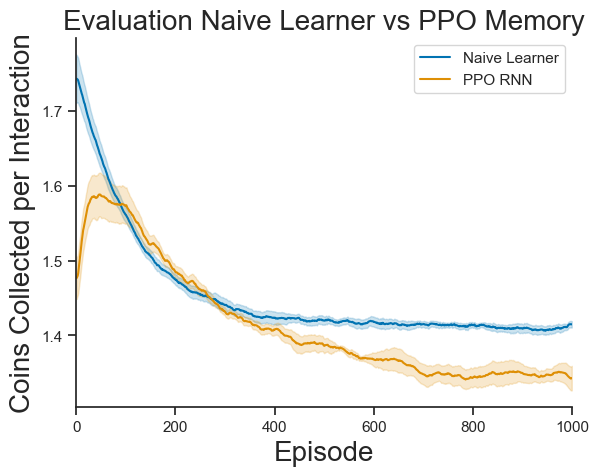

In [51]:
figure_name = "ipditm/eval/independent_total_coins"
smooth_factor = 0.99

_xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Naive Learner", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)

# plt.legend(loc="lower right")
plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Coins Collected per Interaction", fontsize=20)
plt.title("Evaluation Naive Learner vs PPO Memory", fontsize=20)
# plt.legend(loc="lower right")

plt.legend()
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

## Reward

In [52]:
## Reward Per Episode
xs, ys, zs = [], [], []

keys = ['train_iteration', 'train/total_reward/player_1', 'train/total_reward/player_2']
for run in runs:
    print(run.name)
    df = run.scan_history(keys=keys)
    xs.append([row[keys[0]] for row in df])
    ys.append([row[keys[1]] for row in df])
    zs.append([row[keys[2]] for row in df])

run-seed-7
run-seed-5
run-seed-3
run-seed-1
run-seed-0


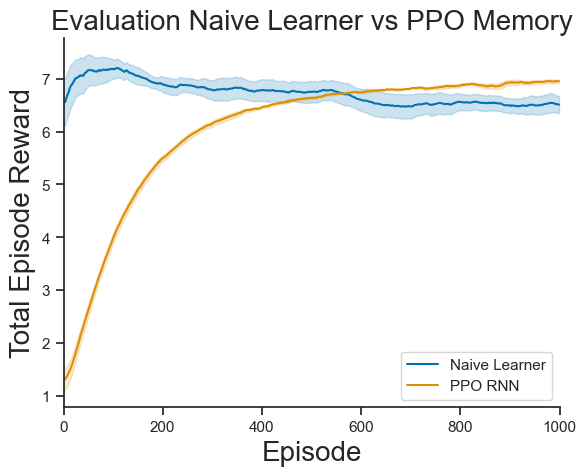

In [53]:
figure_name = "ipditm/eval/independent_episode_reward"
smooth_factor = 0.99

xs = np.array(xs)
_ys = vmap_smooth(np.array(ys), smooth_factor)
_zs = vmap_smooth(np.array(zs), smooth_factor)

x = _xs[0, :]
y = np.median(_ys, axis=0)
z = np.median(_zs, axis=0)

y_std = np.std(_ys, axis=0)
z_std = np.std(_zs, axis=0)

plt.plot(x, y, label="Naive Learner", color='#0173b2')
plt.fill_between(x, y-y_std, y+y_std, color='#0173b2', alpha=0.2)

plt.plot(x, z, label="PPO RNN", color='#de8f05')
plt.fill_between(x, z - z_std, z + z_std, color='#de8f05', alpha=0.2)
# plt.legend(loc="lower right")

plt.plot()
plt.legend()
plt.xlim(0, 1000)
plt.savefig(f"{figure_name}.png", bbox_inches='tight')

plt.xlabel("Episode", fontsize=20)
plt.ylabel("Total Episode Reward", fontsize=20)
plt.title("Evaluation Naive Learner vs PPO Memory",fontsize=20)
# plt.legend(loc="lower right")
plt.legend()
plt.savefig(f"{figure_name}.png", bbox_inches='tight')